In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
df = pd.read_csv("./bse_eq_15min_2018_2025.csv").set_index("datetime").drop(columns=["timestamp"])

In [ ]:
df

,open,high,low,close,volume
datetime,,,,,
2018-01-01 09:30:00+05:30,101.89,103.22,101.79,103.00,330300
2018-01-01 09:45:00+05:30,103.00,103.78,102.67,103.06,306486
2018-01-01 10:00:00+05:30,103.06,103.33,102.79,103.11,182691
2018-01-01 10:15:00+05:30,103.11,103.66,102.95,103.42,125217
2018-01-01 10:30:00+05:30,103.42,103.56,103.28,103.44,58653
...,...,...,...,...,...
2025-12-12 14:30:00+05:30,2731.00,2736.50,2731.00,2736.20,78913
2025-12-12 14:45:00+05:30,2736.50,2736.50,2726.50,2735.60,125254
2025-12-12 15:00:00+05:30,2735.70,2743.70,2733.50,2739.90,154848


#### Creating Technical Analysis features

    Calculate relative volume ratio

In [ ]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    Calculate RSI

In [ ]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    49024.000000
mean        48.916402
std         17.922074
min          0.000000
25%         36.000000
50%         48.840841
75%         61.587403
max         99.194210
Name: rsi_14, dtype: float64

Overbought (>70): 6523 bars
Oversold (<30): 7823 bars


In [ ]:
df.head()

,open,high,low,close,volume,volume_ma,volume_ratio,rsi_14
datetime,,,,,,,,
2018-01-02 11:15:00+05:30,103.57,103.82,103.57,103.73,155808,95521.05,1.631138,51.102941
2018-01-02 11:30:00+05:30,103.73,103.89,103.69,103.89,89190,98239.05,0.907887,53.819444
2018-01-02 11:45:00+05:30,103.89,104.06,103.78,103.89,62109,100180.35,0.619972,51.985560
2018-01-02 12:00:00+05:30,103.89,103.97,103.83,103.92,22977,99982.80,0.229810,54.646840
2018-01-02 12:15:00+05:30,103.93,103.97,103.81,103.89,32706,98963.10,0.330487,61.764706


    MACD

In [ ]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
          macd_norm  macd_hist_norm
count  49024.000000    49024.000000
mean       0.000360        0.000004
std        0.006217        0.001692
min       -0.038312       -0.021902
25%       -0.002589       -0.000732
50%       -0.000141       -0.000044
75%        0.002879        0.000658
max        0.043614        0.014145


    Moving averages

In [ ]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [ ]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

#### Candlestick/Microsturcture Features

In [ ]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (48785, 44)


#### Create log returns target

In [ ]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

In [ ]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

#### Creating lagged features

In [ ]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

In [ ]:
df

,open,high,low,close,volume,volume_ma,volume_ratio,rsi_14,macd,macd_signal,...,vwap_10_diff,close_position_change,body_size_ratio,buying_pressure,selling_pressure,close_log_return,shifted_log_return,close_log_return_lag1,close_log_return_lag2,close_log_return_lag3
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-12 14:15:00+05:30,104.36,104.46,104.23,104.38,34290,79553.25,0.431032,38.297872,-0.084575,-0.063172,...,0.000063,0.366460,0.259816,0.652174,0.347826,0.000192,0.000383,0.000192,0.000959,-0.000671
2018-01-12 14:30:00+05:30,104.42,104.57,104.33,104.42,74088,77601.15,0.954728,37.634409,-0.077660,-0.066070,...,0.000622,-0.277174,0.000000,0.375000,0.625000,0.000383,0.000957,0.000383,0.000192,0.000959
2018-01-12 14:45:00+05:30,104.42,104.56,104.38,104.52,59004,77175.45,0.764544,43.137255,-0.063380,-0.065532,...,0.001820,0.402778,1.406335,0.777778,0.222222,0.000957,0.009522,0.000957,0.000383,0.000192
2018-01-12 15:00:00+05:30,104.52,106.11,104.41,105.52,2043855,176017.05,11.611688,71.287129,0.028302,-0.046765,...,0.003469,-0.124837,6.146111,0.652941,0.347059,0.009522,0.017008,0.009522,0.000957,0.000383
2018-01-12 15:15:00+05:30,105.46,107.48,105.09,107.33,2132487,280313.10,7.607518,84.816754,0.244198,0.011428,...,0.010968,0.284297,5.759014,0.937238,0.062762,0.017008,-0.002145,0.017008,0.009522,0.000957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-12 14:15:00+05:30,2731.80,2737.30,2731.00,2731.00,114859,153149.45,0.749980,89.243697,12.722016,11.922257,...,0.002252,-0.476190,0.279830,0.000000,1.000000,-0.000183,0.001902,-0.000183,0.000842,0.000696
2025-12-12 14:30:00+05:30,2731.00,2736.50,2731.00,2736.20,78913,128614.20,0.613564,88.652482,12.969928,12.131792,...,0.003383,0.945455,2.048542,0.945455,0.054545,0.001902,-0.000219,0.001902,-0.000183,0.000842
2025-12-12 14:45:00+05:30,2736.50,2736.50,2726.50,2735.60,125254,118641.35,1.055736,90.252708,12.968492,12.299132,...,0.002446,-0.035455,0.374042,0.910000,0.090000,-0.000219,0.001571,-0.000219,0.001902,-0.000183


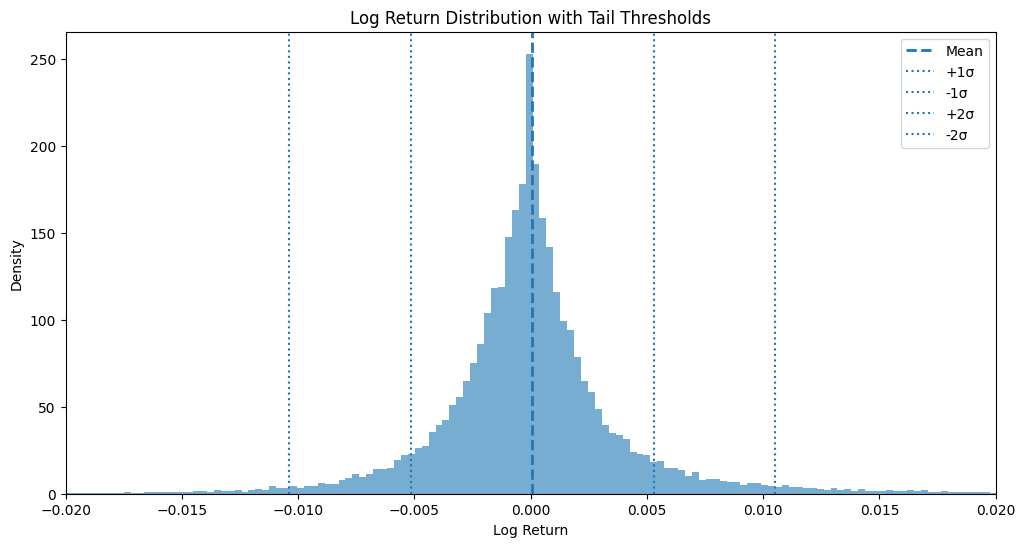

In [ ]:
y_clean = df["close_log_return"].dropna()

mu = y_clean.mean()
sigma = y_clean.std()

fig, ax = plt.subplots(figsize=(12, 6))

# Histogram
ax.hist(
    y_clean,
    bins=1000,
    density=True,
    alpha=0.6
)
ax.set_xlim(-0.02, 0.02)
# Mean & std lines
ax.axvline(mu, linestyle="--", linewidth=2, label="Mean")
ax.axvline(mu + sigma, linestyle=":", linewidth=1.5, label="+1σ")
ax.axvline(mu - sigma, linestyle=":", linewidth=1.5, label="-1σ")
ax.axvline(mu + 2*sigma, linestyle=":", linewidth=1.5, label="+2σ")
ax.axvline(mu - 2*sigma, linestyle=":", linewidth=1.5, label="-2σ")


ax.set_title("Log Return Distribution with Tail Thresholds")
ax.set_xlabel("Log Return")
ax.set_ylabel("Density")

ax.legend(loc="upper right")
plt.show()


In [ ]:
# X = df[[
#     # Lagged returns
#     "close_log_return_lag1", 
#     "close_log_return_lag2", 
#     "close_log_return_lag3",
    
#     # Volume
#     "volume_ratio",
    
#     # Momentum
#     "rsi_14",
    
 
#     # MACD
#     "macd_norm",
#     "macd_hist_norm",
    
#     # Moving Average features (normalized)
#     "5_10_ma_diff_pct",
#     "close_5ma_diff_pct",
#     "close_10ma_diff_pct",
#     "close_50ma_diff_pct",
#     "close_200ma_diff_pct",
#     "golden_cross_pct",


#     "hl_range_ratio",
#     "close_position"

# ]]
# y = (df["shifted_log_return"] > 0).astype(int)

In [ ]:
# # Keep only features with importance > 0.06
# X = df[[
#     # Top tier (>0.09)
#     "close_position",
#     "close_5ma_diff_pct",
    
#     # Strong tier (0.065-0.075)
#     "close_log_return_lag1",
#     "volume_ratio",
#     "macd_norm",
    
#     # Decent tier (0.06-0.065)
#     "close_10ma_diff_pct",
#     "5_10_ma_diff_pct",
#     "macd_hist_norm",
#     "close_50ma_diff_pct",
#     "hl_range_ratio"
# ]]
# y = (df["shifted_log_return"] > 0).astype(int)
# # Drop weak features
# # "rsi_14", "golden_cross_pct", "close_200ma_diff_pct", 
# # "close_log_return_lag2", "close_log_return_lag3"

In [ ]:
X = df[[
    "buying_pressure",
    "selling_pressure",
    "close_position",
    "close_5ma_diff_pct",
    "high_close_diff",
    "vwap_5_diff",
    "body_size",
    "body_size_ratio",
    "volume_ratio",
    "low_close_diff"
]]


y = (df["shifted_log_return"] > 0).astype(int)


In [ ]:
y

datetime
2018-01-12 14:15:00+05:30    1
2018-01-12 14:30:00+05:30    1
2018-01-12 14:45:00+05:30    1
2018-01-12 15:00:00+05:30    1
2018-01-12 15:15:00+05:30    0
                            ..
2025-12-12 14:15:00+05:30    1
2025-12-12 14:30:00+05:30    0
2025-12-12 14:45:00+05:30    1
2025-12-12 15:00:00+05:30    0
2025-12-12 15:15:00+05:30    0
Name: shifted_log_return, Length: 48780, dtype: int64

In [ ]:
X

,buying_pressure,selling_pressure,close_position,close_5ma_diff_pct,high_close_diff,vwap_5_diff,body_size,body_size_ratio,volume_ratio,low_close_diff
datetime,,,,,,,,,,
2018-01-12 14:15:00+05:30,0.652174,0.347826,0.652174,0.000651,0.000766,0.000816,0.000192,0.259816,0.431032,0.001437
2018-01-12 14:30:00+05:30,0.375000,0.625000,0.375000,0.000670,0.001437,0.000738,0.000000,0.000000,0.954728,0.000862
2018-01-12 14:45:00+05:30,0.777778,0.222222,0.777778,0.001263,0.000383,0.001371,0.000957,1.406335,0.764544,0.001339
2018-01-12 15:00:00+05:30,0.652941,0.347059,0.652941,0.008340,0.005591,0.001113,0.009477,6.146111,11.611688,0.010519
2018-01-12 15:15:00+05:30,0.937238,0.062762,0.937238,0.019529,0.001398,0.008970,0.017423,5.759014,7.607518,0.020870
...,...,...,...,...,...,...,...,...,...,...
2025-12-12 14:15:00+05:30,0.000000,1.000000,0.000000,0.000681,0.002307,0.000566,0.000293,0.279830,0.749980,0.000000
2025-12-12 14:30:00+05:30,0.945455,0.054545,0.945455,0.001886,0.000110,0.001912,0.001900,2.048542,0.613564,0.001900
2025-12-12 14:45:00+05:30,0.910000,0.090000,0.910000,0.001060,0.000329,0.001103,0.000329,0.374042,1.055736,0.003327


#### Preparing Model

[0 1 0 ... 1 1 0]
Test score - 0.5093275932759328
Validation score - 0.510660106601066
Train score - 1.0
Train confusion matrix - [[2809 2241]
 [2546 2160]]
              precision    recall  f1-score   support

           0       0.52      0.56      0.54      5050
           1       0.49      0.46      0.47      4706

    accuracy                           0.51      9756
   macro avg       0.51      0.51      0.51      9756
weighted avg       0.51      0.51      0.51      9756

Training Accuracy Scores: [0.5622864561978953, 0.5712040453737871, 0.5792674593412601]
Validation Accuracy Scores: [0.536490364903649, 0.5485854858548586, 0.550840508405084]


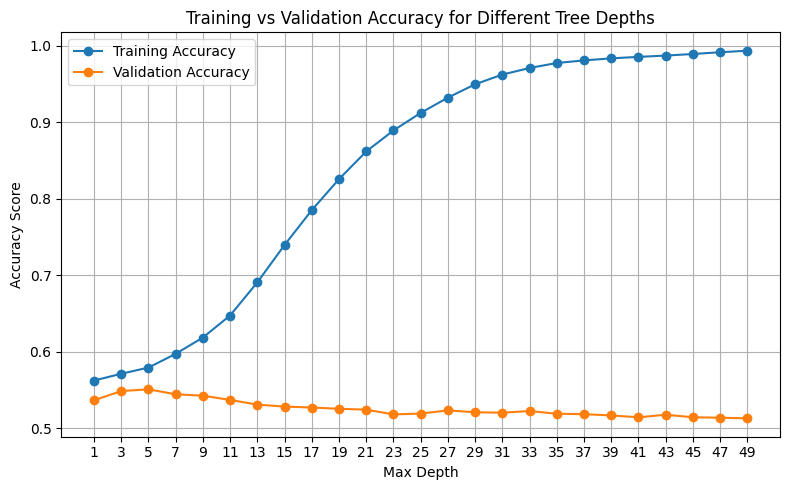

In [ ]:
model_preparation(X, y)

In [ ]:
model = best_model(X, y, max_depth=5)

Test score - 0.5252152521525215
Validation score - 0.550840508405084
Train score - 0.5792674593412601
Train confusion matrix - [[3569 1481]
 [3151 1555]]
              precision    recall  f1-score   support

           0       0.53      0.71      0.61      5050
           1       0.51      0.33      0.40      4706

    accuracy                           0.53      9756
   macro avg       0.52      0.52      0.50      9756
weighted avg       0.52      0.53      0.51      9756



In [ ]:
equity_df = pd.DataFrame()
equity_df["y_true"] = y
equity_df["y_pred"] = model.predict(X)
equity_df["log_returns"] = df["shifted_log_return"]
y_proba = model.predict_proba(X)

In [ ]:
df["shifted_log_return"]

datetime
2018-01-12 14:15:00+05:30    0.000383
2018-01-12 14:30:00+05:30    0.000957
2018-01-12 14:45:00+05:30    0.009522
2018-01-12 15:00:00+05:30    0.017008
2018-01-12 15:15:00+05:30   -0.002145
                               ...   
2025-12-12 14:15:00+05:30    0.001902
2025-12-12 14:30:00+05:30   -0.000219
2025-12-12 14:45:00+05:30    0.001571
2025-12-12 15:00:00+05:30   -0.000548
2025-12-12 15:15:00+05:30   -0.003695
Name: shifted_log_return, Length: 48780, dtype: float64

    After adding transaction costs

In [ ]:
# Step 1: Position based on prediction
equity_df['position'] = equity_df['y_pred']

# Step 2: Transaction costs - only when position changes (round trip)
TRANSACTION_COST_PCT = 0.0004  # 0.04% per round trip

# Detect position changes (entry/exit = round trip)
equity_df['position_change'] = equity_df['position'].diff().fillna(equity_df['position']).abs()

# Cost applied per $100 position when trade happens
equity_df['transaction_cost'] = equity_df['position_change'] * 100 * TRANSACTION_COST_PCT

# Step 3: Calculate P&L for each independent $100 trade
equity_df['pnl_gross'] = equity_df['position'] * equity_df['log_returns'] * 100
equity_df['pnl_net'] = equity_df['pnl_gross'] - equity_df['transaction_cost']

# Step 4: Calculate cumulative P&L (simple sum, not compounding)
equity_df['cumulative_pnl'] = equity_df['pnl_net'].cumsum()

# Step 5: Equity curve (starting capital + cumulative P&L)
equity_df['equity'] = 100 + equity_df['cumulative_pnl']

# Summary statistics
total_trades = (equity_df['position_change'] > 0).sum()  # Actual trades (position changes)
total_bars = len(equity_df)
winning_trades = (equity_df['pnl_net'] > 0).sum()
losing_trades = (equity_df['pnl_net'] < 0).sum()

total_gross_pnl = equity_df['pnl_gross'].sum()
total_costs = equity_df['transaction_cost'].sum()
total_net_pnl = equity_df['pnl_net'].sum()

print(f"\n{'='*50}")
print(f"PERFORMANCE SUMMARY")
print(f"{'='*50}")
print(f"Total bars: {total_bars}")
print(f"Total trades (position changes): {total_trades}")
print(f"Winning bars: {winning_trades}")
print(f"Losing bars: {losing_trades}")
print(f"Win rate: {winning_trades / total_bars * 100:.2f}%")
print(f"\nGross P&L: ${total_gross_pnl:.2f}")
print(f"Transaction costs: ${total_costs:.2f} ({total_costs/abs(total_gross_pnl)*100:.2f}% of gross)")
print(f"Net P&L: ${total_net_pnl:.2f}")
print(f"Final equity: ${equity_df['equity'].iloc[-1]:.2f}")
print(f"Net Return: {total_net_pnl:.2f}%")
print(f"\nAvg win: ${equity_df[equity_df['pnl_net'] > 0]['pnl_net'].mean():.2f}")
print(f"Avg loss: ${equity_df[equity_df['pnl_net'] < 0]['pnl_net'].mean():.2f}")

total_wins = equity_df[equity_df['pnl_net'] > 0]['pnl_net'].sum()
total_losses = abs(equity_df[equity_df['pnl_net'] < 0]['pnl_net'].sum())
profit_factor = (total_wins / total_losses) if total_losses > 0 else np.inf

print(f"Profit factor: {profit_factor:.2f}")
print(f"\nSharpe Ratio: {equity_df['pnl_net'].mean() / equity_df['pnl_net'].std() * np.sqrt(252 * 75):.2f}")

drawdown = equity_df['equity'].cummax() - equity_df['equity']
max_dd = drawdown.max()
max_dd_pct = (max_dd / equity_df['equity'].cummax()[drawdown.idxmax()]) * 100

print(f"Max Drawdown: ${max_dd:.2f} ({max_dd_pct:.2f}%)")
print(f"{'='*50}\n")


PERFORMANCE SUMMARY
Total bars: 48780
Total trades (position changes): 18696
Winning bars: 7689
Losing bars: 17128
Win rate: 15.76%

Gross P&L: $465.43
Transaction costs: $747.84 (160.68% of gross)
Net P&L: $-282.41
Final equity: $-182.41
Net Return: -282.41%

Avg win: $0.30
Avg loss: $-0.15
Profit factor: 0.89

Sharpe Ratio: -2.72
Max Drawdown: $295.34 (267.00%)



#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
params = {
    "randomforestclassifier__n_estimators":range(25,100,25),
    "randomforestclassifier__max_depth":range(10,50,10),
}

In [ ]:
clf = make_pipeline(RandomForestClassifier(random_state=42))


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# 1. Sequential outer split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 2. TimeSeriesSplit for GridSearchCV (respects time order)
tscv = TimeSeriesSplit(n_splits=5)

model = GridSearchCV(
    clf, 
    param_grid=params,
    cv=tscv,  # This is the critical change
    n_jobs=-1,
    verbose=1
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.6743
Test Accuracy: 0.5278


In [ ]:
confusion_matrix(y_test, model.predict(X_test))

array([[3659, 1391],
       [3216, 1490]])

In [ ]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.72      0.61      5050
           1       0.52      0.32      0.39      4706

    accuracy                           0.53      9756
   macro avg       0.52      0.52      0.50      9756
weighted avg       0.52      0.53      0.51      9756



#### XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Define parameter grid
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# TimeSeriesSplit CV
tscv = TimeSeriesSplit(n_splits=5)

# GridSearch
model = GridSearchCV(
    xgb_model,
    param_grid=params,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Sequential split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train
model.fit(X_train, y_train)

# Evaluate
print(f"Best params: {model.best_params_}")
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print(f"Training Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


KeyboardInterrupt: 


FEATURE IMPORTANCE (GridSearchCV Best Model)
           feature  importance
    close_position    0.205509
   buying_pressure    0.205045
  selling_pressure    0.176959
   high_close_diff    0.101148
close_5ma_diff_pct    0.080262
       vwap_5_diff    0.054128
      volume_ratio    0.046999
         body_size    0.046084
   body_size_ratio    0.043512
    low_close_diff    0.040353

Top 5 features account for: 76.89% of total importance
Top 10 features account for: 100.00% of total importance



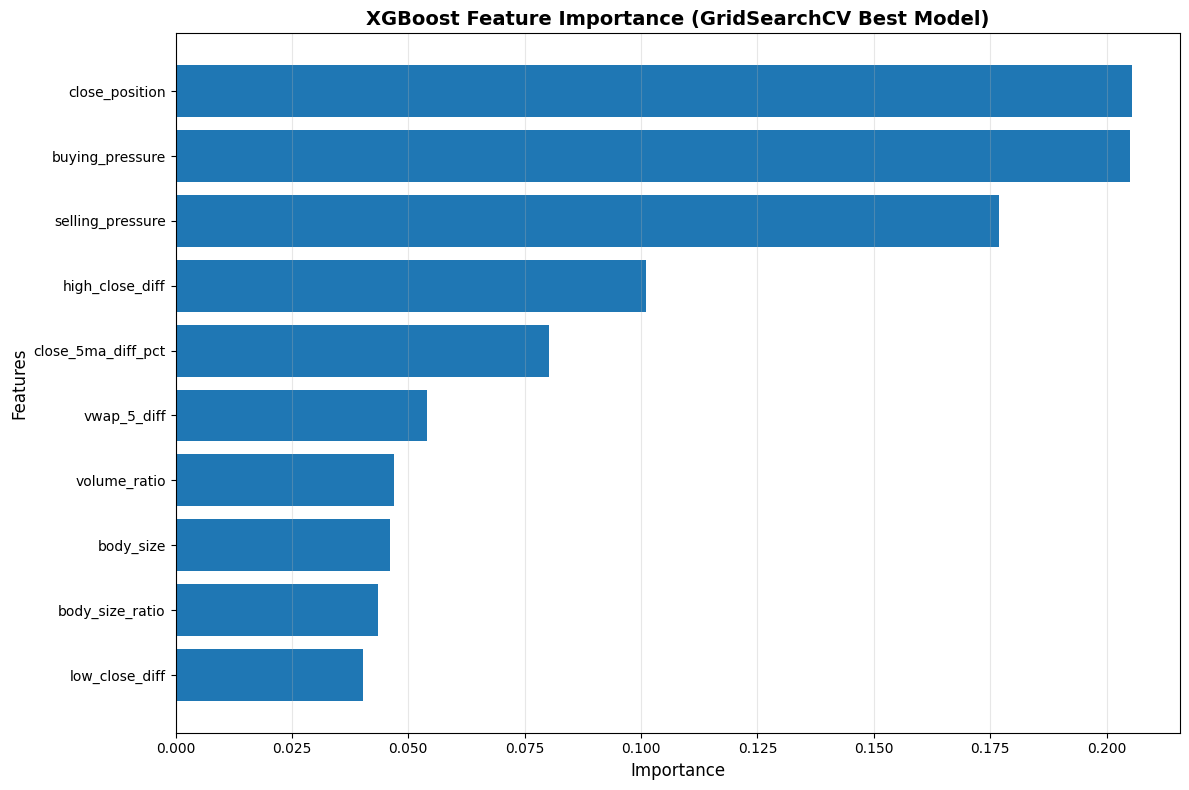


Top 10 Most Important Features:
close_position                 : 0.2055
buying_pressure                : 0.2050
selling_pressure               : 0.1770
high_close_diff                : 0.1011
close_5ma_diff_pct             : 0.0803
vwap_5_diff                    : 0.0541
volume_ratio                   : 0.0470
body_size                      : 0.0461
body_size_ratio                : 0.0435
low_close_diff                 : 0.0404


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance from the best model in GridSearchCV
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (GridSearchCV Best Model)")
print("="*60)
print(feature_importance.to_string(index=False))

# Summary stats
print(f"\n{'='*60}")
print(f"Top 5 features account for: {feature_importance.head(5)['importance'].sum():.2%} of total importance")
print(f"Top 10 features account for: {feature_importance.head(10)['importance'].sum():.2%} of total importance")
print(f"{'='*60}\n")

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('XGBoost Feature Importance (GridSearchCV Best Model)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Optional: Compare top features before and after
print("\nTop 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:30s} : {row['importance']:.4f}")  